#  Monte Carlo Integrals

##### Keywords: monte-carlo, integration, uniform distribution, law of large numbers, lotus, central limit theorem, normal distribution

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist

sns.set_style("white")
colors=sns.color_palette()

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', False)

## The basic idea

Let us formalize the basic idea behind Monte Carlo Integration in 1-D.

Consider the definite integral:

$$ I = \int_{a}^{b} f(x) \, dx $$

Consider:

$$ J = \int_{a}^{b} f(x) U_{ab}(x) \, dx $$

If $V$ is the support of the uniform distribution on  a to b then the pdf
$$ U_{ab}(x) = \frac{1}{V} = \frac{1}{b-a}$$

Then from LOTUS and the law of large numbers:

$$J = \frac{1}{V}  \int_{a}^{b} f(x) \, dx  =  \frac{I}{V} = E_{U}[f] = \lim_{n \to \infty} \frac{1}{N}\sum_{x_i \sim U} f(x_i) $$

or

$$I  = V  \times \lim_{n \to \infty} \frac{1}{N}\sum_{x_i \sim U} f(x_i) $$

Practically speaking, our estimate will only be as exact as the number of samples we draw, but more on this soon..

### Example. 

**Calculate the integral $ I= \int_{2}^{3} [x^2 + 4 \, x \,\sin(x)] \, dx. $**

We know from calculus that the anti-derivative is 
$$ x^3/3 + 4\sin(x) -4x\cos(x). $$ 

To solve this using MC, we simply draw $N$ random numbers from 2 to 3 and then take the average of all the values $f(x)=x^2 + 4 \, x \,\sin(x)$ and normalized over the volume; this case the volume is 1 (3-2=1). 

In [2]:
def f(x):
    return x**2 + 4*x*np.sin(x) 

def intf(x): 
    return x**3/3.0+4.0*np.sin(x) - 4.0*x*np.cos(x) 

In [4]:
a = 2;    
b = 3; 

# use N draws 
N= 10000

X = dist.Uniform(a, b).sample((N,)).numpy() # N values uniformly drawn from a to b 
Y =f(X)   # CALCULATE THE f(x) 
V = b-a
Imc= V * np.sum(Y)/ N;

exactval=intf(b)-intf(a)

print("Monte Carlo estimation=",Imc, "Exact number=", intf(b)-intf(a))


Monte Carlo estimation= 11.81274375 Exact number= 11.811358925098283


### Mutlidimensional integral. 
That is nice but how about a multidimensional case? 

Let us calculate the two dimensional integral $I=\int \int f(x, y) dx dy$ where $f(x,y) = x^2 +y^2$ 
over the region deﬁned by the condition $x^2 +y^2 ≤ 1$

In other words we are talking about a uniform distribution on the unit circle


In [5]:
fmd = lambda x,y: x*x + y*y

In [6]:
# use N draws 
N= 8000
X= dist.Uniform(-1, 1).sample((N,)).numpy()
Y= dist.Uniform(-1, 1).sample((N,)).numpy() 
Z=fmd(X, Y)   # CALCULATE THE f(x) 

R = X**2 + Y**2
V = np.pi*1.0*1.0
N = np.sum(R<1)
sumsamples = np.sum(Z[R<1])

print("I=",V*sumsamples/N, "actual", np.pi/2.0) #actual value (change to polar to calculate)

I= 1.5479135447531593 actual 1.5707963267948966


## Monte-Carlo as a function of number of samples

How does the accuracy depends on the number of points(samples)? Lets try the same 1-D integral $ I= \int_{2}^{3} [x^2 + 4 \, x \,\sin(x)] \, dx $ as a function of the number of points. 

/home/rashed/.local/share/virtualenvs/Stochastic-Optimization-g1LdcETT/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'sqrt((Imc-ExactValue)$^2$)')

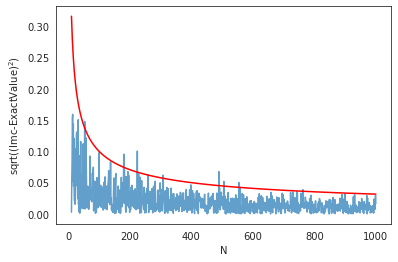

In [8]:
Imc=np.zeros(1000)
Na = np.linspace(0,1000,1000)

exactval= intf(b)-intf(a)

for N in np.arange(0, 1000):
    X = dist.Uniform(a, b).sample((N,)).numpy() # N values uniformly drawn from a to b 
    Y =f(X)   # CALCULATE THE f(x) 

    Imc[N]= (b-a) * np.sum(Y)/ N;
    
    
plt.plot(Na[10:],np.sqrt((Imc[10:]-exactval)**2), alpha=0.7)
plt.plot(Na[10:], 1/np.sqrt(Na[10:]), 'r')
plt.xlabel("N")
plt.ylabel("sqrt((Imc-ExactValue)$^2$)")

Obviously this depends on the number of $N$ as $1/\sqrt{N}$. 

## Errors in MC

Monte Carlo methods yield approximate
answers whose accuracy depends on the number of draws.
So far, we have used our knowledge of the exact value  to determine that the
error in the Monte Carlo method approaches zero as approximately $1/\sqrt{N}$ for large $N$, where $N$ is the number of trials. 

But in the usual case, the exact answer is unknown. Why do this otherwise?

So, lets repeat the same evaluation $m$ times and check the variance of the estimate. 

11.81167582421875 0.004239867928659472


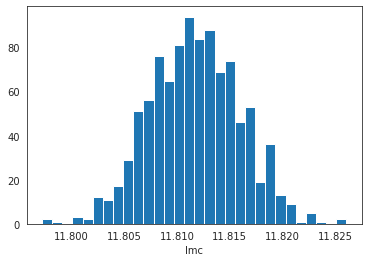

In [9]:
# multiple MC estimations
m=1000
N=10000
Imc=np.zeros(m)


for i in np.arange(m):
    
    X = dist.Uniform(a, b).sample((N,)).numpy() # N values uniformly drawn from a to b 
    Y =f(X)   # CALCULATE THE f(x) 

    Imc[i]= (b-a) * np.sum(Y)/ N;
    
    
plt.hist(Imc, bins=30)
plt.xlabel("Imc")
print(np.mean(Imc), np.std(Imc))


This looks like our telltale Normal distribution.

This is not surprising

### Estimating the error in MC integration using the CLT.

We know from the CLT that if $x_1,x_2,...,x_n$ be a sequence of independent, identically-distributed (IID) random variables from a random variable $X$, and that if $X$ has the finite mean $\mu$ AND finite variance $\sigma^2$. 

Then, 

$$S_n = \frac{1}{n} \sum_{i=1}^{n} x_i ,$$

**converges to a Gaussian Random Variable with mean $\mu$ and variance $\sigma^2/n$ as $n \to \infty$:**

$$ S_n \sim N(\mu,\frac{\sigma^2}{n}) \, as \, n \to \infty. $$


This is true *regardless* of the shape of $X$, which could be binomial, poisson, or any other distribution.

The sums

$$S_n(f) = \frac{1}{n} \sum_{i=1}^{n} f(x_i) $$

are exactly what we want to calculate for Monte-Carlo Integration(due to the LOTUS) and correspond to the random variable f(X) where X is uniformly distributed on the support.

Whatever the original variance of f(X) might be, we can see that the variance of the sampling distribution of the mean goes down as $1/n$ and thus the standard error goes down as $1/\sqrt{n}$ as we discovered when we compared it to the exact value as well.

Why is this important?




### Comparing to standard integration techniques

What if we changed the dimensionality of the integral? The formula for $S_n$ does not change, we just replace $g(x_i)$ by $g(x_i, y_i, z_i...)$. Thus, the CLT still holds and the error still scales as $\frac{1}{\sqrt{n}}$.

On the other hand, if we divide the $a, b$-interval into $N$ 
steps and use some regular integration routine, what is the error? Consider the midpoint rule as illustrated in this diagram from Wikipedia:

![](https://upload.wikimedia.org/wikipedia/commons/5/5b/Rectangle_rule.gif)

The basic idea is that the function value at the midpoint of the interval is used as the height of the approximating rectangle. In general, the differing methods consist of choosing different $x_i$ below..with left being at the left end, right being at the right end. 
$$I(est) = \sum_i f(x_i)\Delta x_i = \frac{b-a}{n} \sum_i f(x_i)$$

The error on the estimation of the integral can be shown to decrease as $\frac{1}{n^2}$. The basic reason for this can be understood on a taylor series expansion of the function to second order. When you integrate on the sub-interval, the linear term vanishes while the quadratic term becomes cubic in $\Delta x$. So the local error goes as $\frac{1}{n^3}$ and thus the global as  $\frac{1}{n^2}$.

Monte-Carlo if clearly not competitive with the midpoint method in 1-D. Its actually not even competitive with left or right rectangle methods.

The trapeziod rule uses a line between the sub-interval points while the  Simpsons rule uses a quadratic.

These integrations can be generalized  to multiple dimensions, and the rule for these


* left or right rule:  $\propto 1/n$
* Midpoint rule: $\propto 1/n^2$
* Trapezoid: $\propto 1/n^2$
* Simpson: $\propto 1/n^4$

where $n=N^{1/d}$. MC becomes better than the Simpson method only in 8 dimensions..